# Реализация и сравнение моделей прогнозирования временных рядов

In [1]:
import matplotlib.pyplot as plt
from numpy.linalg import inv
import pandas as pd
import numpy as np

%matplotlib inline

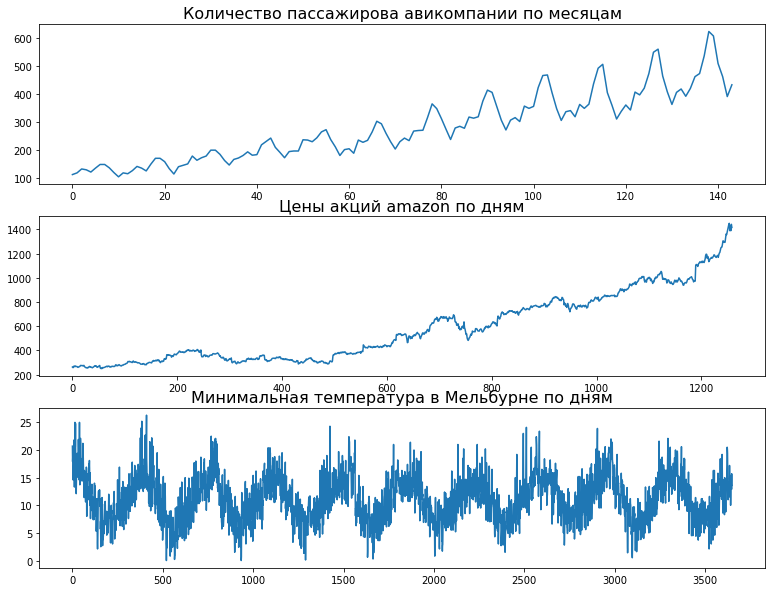

In [2]:
airlines = pd.read_csv('data/airline.csv')['0']
amazon = pd.read_csv('data/amazon_price.csv')['0']
temperature = pd.read_csv('data/temperature.csv')['0']

fig, ax = plt.subplots(3,1)
fig.set_size_inches(13, 10)

ax[0].plot(airlines)
ax[0].set_title('Количество пассажирова авикомпании по месяцам', fontsize=16)
ax[1].plot(amazon)
ax[1].set_title('Цены акций amazon по дням', fontsize=16)
ax[2].plot(temperature)
ax[2].set_title('Минимальная температура в Мельбурне по дням', fontsize=16)

plt.show()

In [3]:
def split_data(df, percent=0.66):
    """Разделяет данные на обучающие и тестовые"""
    size = int(len(df) * percent)
    return df[:size].copy(), df[size:].copy()


def loss_function(y_real, prediction):
    """Ф-ия потерь. Средний квадрат ошибки"""
    return np.mean((y_real - prediction)**2)


def start_model(model, train_y, test_y, predict_period, is_ln=False, is_recalculate_model=True):
    """Ф-ия теста модели
    
    Алгоритм действий:
    1) Пролагорифмировать (опционально)
    2) Обучить модель
    3) Предсказывать по одной точке на тестовых данных
    4) Предсказать следующий интервал
    5) Взять экспоненту, если логарифмировали
    6) Визуализация
    """
    # логарифмирование для нормализации дисперсии
    if is_ln:
        train_y = pd.Series([np.log(y) for y in train_y], index=train_y.index.values)
        test_y = pd.Series([np.log(y) for y in test_y], index=test_y.index.values)
    
    # обучение
    model.fit(train_y)
    fit_chart = model.fit_chart[:]

    # прогнозирование на тестовых данных
    prediction_by_test = []
    for x in test_y.index.values:
        prediction_by_test.append(model.predict_y())
        model.append_y(test_y[x]) # пересчет модели по новому значению
    
    # предсказание на некоторый период вперед
    prediction_period = []
    
    # некоторые модели имеют параметр d для предсказания значения i+d, а не только последней точки
    # для других моделей предсказываем значение и пересчитываем модель, передавая прогноз как новый y
    if is_recalculate_model:
        for _ in range(predict_period):
            p = model.predict_y()
            prediction_period.append(p)
            model.append_y(p)
    else:
        prediction_period = [model.predict_y(i) for i in range(predict_period)]
    
    # возвращение к исходным данным, если проводилось логарифмирование
    if is_ln:
        train_y = pd.Series([np.exp(y) for y in train_y], index=train_y.index.values)
        test_y = pd.Series([np.exp(y) for y in test_y], index=test_y.index.values)
        fit_chart = [np.exp(y) for y in fit_chart]
        prediction_by_test = [np.exp(y) for y in prediction_by_test]
        prediction_period = [np.exp(y) for y in prediction_period]
    
    # визуализация результатов и вычисление среднего квадрата ошибки
    plt.plot(train_y, color='gray', linewidth=1, label='train real data')
    plt.plot(test_y, color='black', linewidth=1, label='test real data')

    plt.plot(train_y.index.values[-len(fit_chart):], fit_chart, color='blue',
             linewidth=1, label='train predict data')
    plt.plot(test_y.index.values, prediction_by_test, color='orange', linewidth=1, label='test predict data')

    plt.plot([test_y.index.values[-1] + i + 1 for i in range(predict_period)], prediction_period, color='red',
             linewidth=3, label='predict period')

    plt.title(f'avg((y - ŷ)^2) == {loss_function(test_y, prediction_by_test)}')
    
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    
    plt.legend()
    plt.show()

## Примечание:
В случае, если со временем увеличивается дисперсия ряда, имеет смысл прогнозировать пролагорифмированный ряд

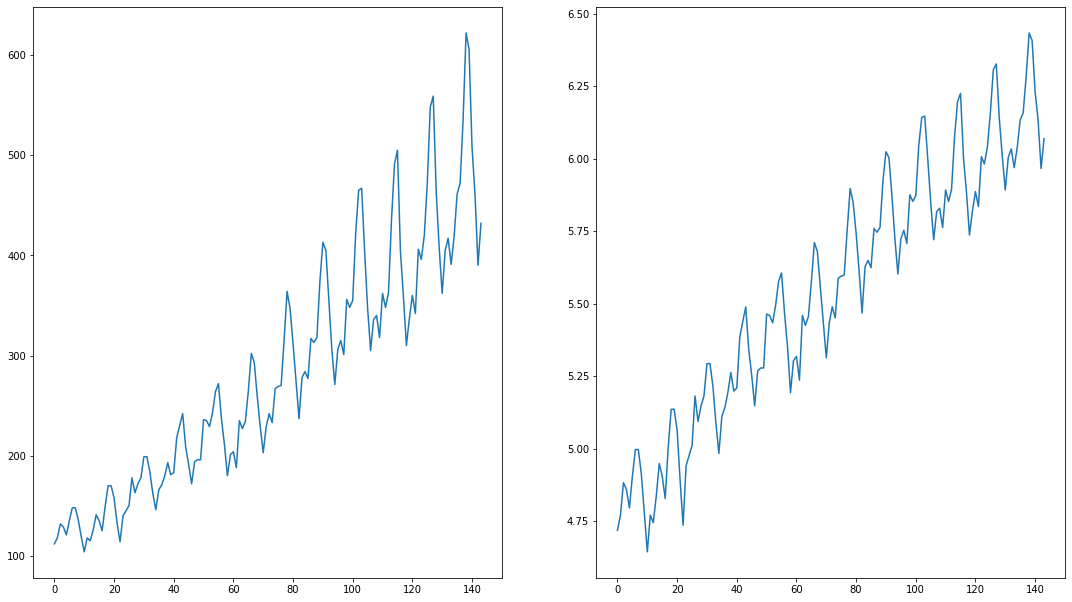

In [4]:
def ln(series):
    """Пример пролагорифмированных данных"""
    ln_series = pd.Series([np.log(y) for y in series], index=series.index.values)
    
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(18.5, 10.5)
    
    ax[0].plot(series)
    ax[1].plot(ln_series)
    
    plt.show()


ln(airlines)

## Экспоненциальная скользящая средняя

Каждый новый элемент вычисляется через формулу:

$$ ŷ[t+1] = ŷ[t] + α(y[t] − ŷ[t]) $$

$ α \in (0, 1) $ и вычисляется по формуле $ α = 1 / (p + 1) $, где $ p $ это период усреднения.

Чем больше $ α $ тем больше вес последних точек.

Является самой простой моделью для прогнозирования рядов.
С ее помощью можно прогнозировать только одно будущее значение.

In [5]:
class EMA:
    """Экспоненциальное скользящее среднее

    ŷ[t+1] = ŷ[t] + α(y[t] − ŷ[t])
    
    α = 1/(p + 1)
    
    Усредняет p предыдущих значений
    Чем больше p, тем более сглаженной будет линия
    
    """

    def __init__(self, p):
        self.alpha = 1 / (p + 1)
        self.last_prediction_y = 0
        self.last_real_y = 0
        self.fit_chart = []

    def fit(self, y):
        for i, y_i in enumerate(y):
            if i == 0:
                # на первой итерации принимаем за среднее первое значение ряда
                self.last_prediction_y = y_i
                self.fit_chart.append(self.last_prediction_y)
                continue
            
            self.last_real_y = y[i - 1]
            self.last_prediction_y += self.alpha * (self.last_real_y - self.last_prediction_y)
            self.fit_chart.append(self.last_prediction_y)
        return self

    def predict_y(self):
        return self.last_prediction_y

    def append_y(self, new_y):
        self.last_real_y = new_y
        self.last_prediction_y += self.alpha * (self.last_real_y - self.last_prediction_y)

Несмотря на то, что сама EMA слабо предсказывает следующее значение (и не может предсказывать будущий ряд), на ее основе строится множество других моделей, некоторые из которых рассматриваются далее.

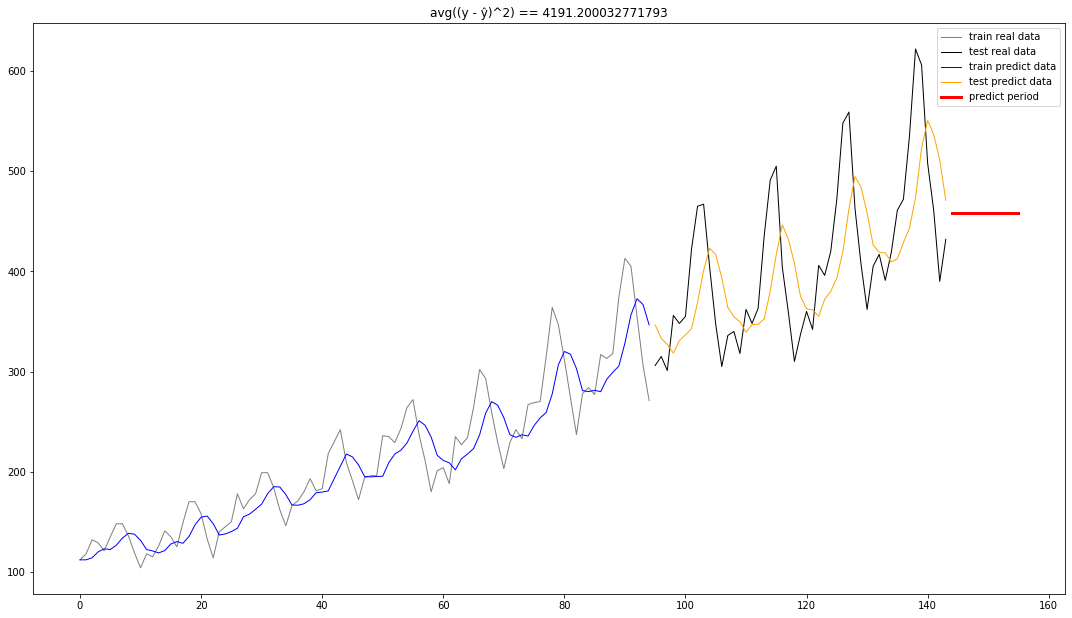

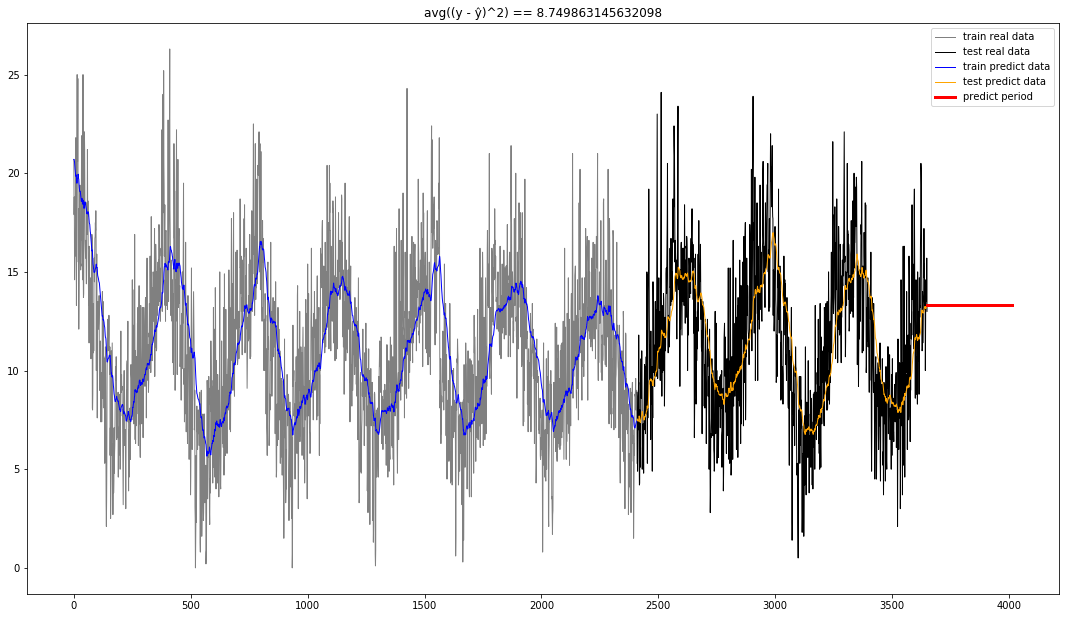

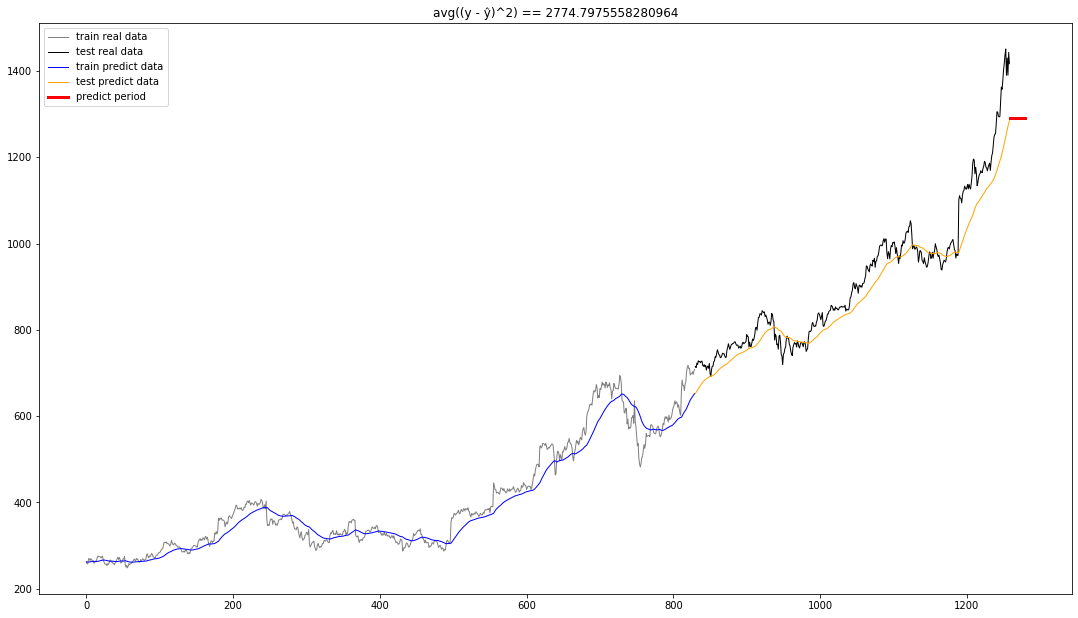

In [6]:
start_model(EMA(2), *split_data(airlines), predict_period=12)
start_model(EMA(30), *split_data(temperature), predict_period=365)
start_model(EMA(21), *split_data(amazon), predict_period=21)

## Модель Хольта

Элементы вычисляются по формуле:

$$ ŷ[t+d] = a[t] + b[t] * d $$

$$ a[t] = α1 * y[t] + (1 − α1) * (a[t−1] + b[t−1]) $$
$$ b[t] = α2 * (a[t] − a[t−1]) + (1 − α2)*b[t − 1] $$

Данная модель предсказывает линейный тренд, игнорируя сезонные колебания.

По факту, данная модель является скользящей средней ($ a[t] $) с учетом темпа роста в момент времени d ($ b[t] * d $).

In [7]:
class Holt:
    """Модель Хольта
    
    ŷ[t+d] = a[t] + b[t] * d
    
    Коэффициенты тренда
    a[t] = α1 * y[t] + (1 − α1) * (a[t−1] + b[t−1])
    b[t] = α2 * (a[t] − a[t−1]) + (1 − α2)*b[t − 1]
    
    α[i] = 1/(p[i] + 1)

    Предсказывает линейный тренд, не учитывает сезонные колебания
    
    """

    def __init__(self, p1, p2):
        self.alpha1 = (1 / (p1 + 1))
        self.alpha2 = (1 / (p2 + 1))
        self.a, self.b = 0, 0
        self.fit_chart = []
        self.last_prediction_y = 0

    def fit(self, y):
        old_y = y[0]
        
        for y_i in y[1:]:
            old_a = self.a
            self.a = self.alpha1 * old_y + (1 - self.alpha1) * (old_a + self.b)
            self.b = self.alpha2 * (self.a - old_a) + (1 - self.alpha2) * self.b
            self.last_prediction_y = self.a + self.b
            
            old_y = y_i
            self.fit_chart.append(self.last_prediction_y)
        return self

    def predict_y(self, d=1):
        if d != 1:
            return self.a + self.b * d
        return self.last_prediction_y

    def append_y(self, new_y):
        old_a = self.a
        self.a = self.alpha1 * new_y + (1 - self.alpha1) * (old_a + self.b)
        self.b = self.alpha2 * (self.a - old_a) + (1 - self.alpha2) * self.b
        self.last_prediction_y = self.a + self.b


Так как первые значения $ a $ и $ b $ равны 0, в начале ряда наблюдается сильное отклонение, которое быстро исчезает.

Как и ожидалось, подобная модель совсем не подходит для прогнозирования данных без тренда и плохо прогнозирует данные, где есть тренд и сезон (указывает только тренд).

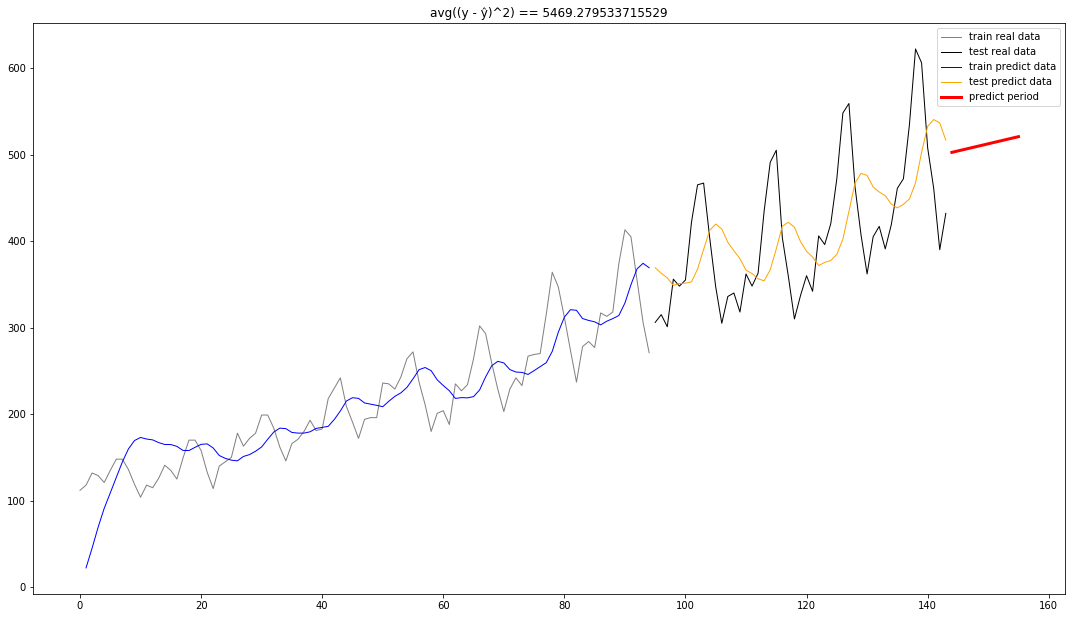

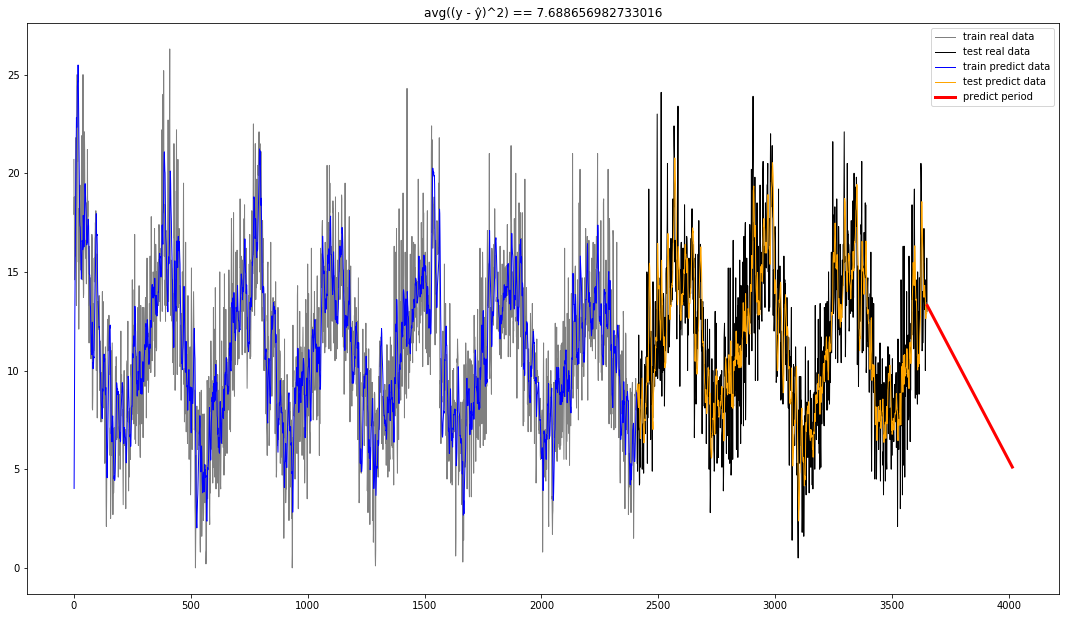

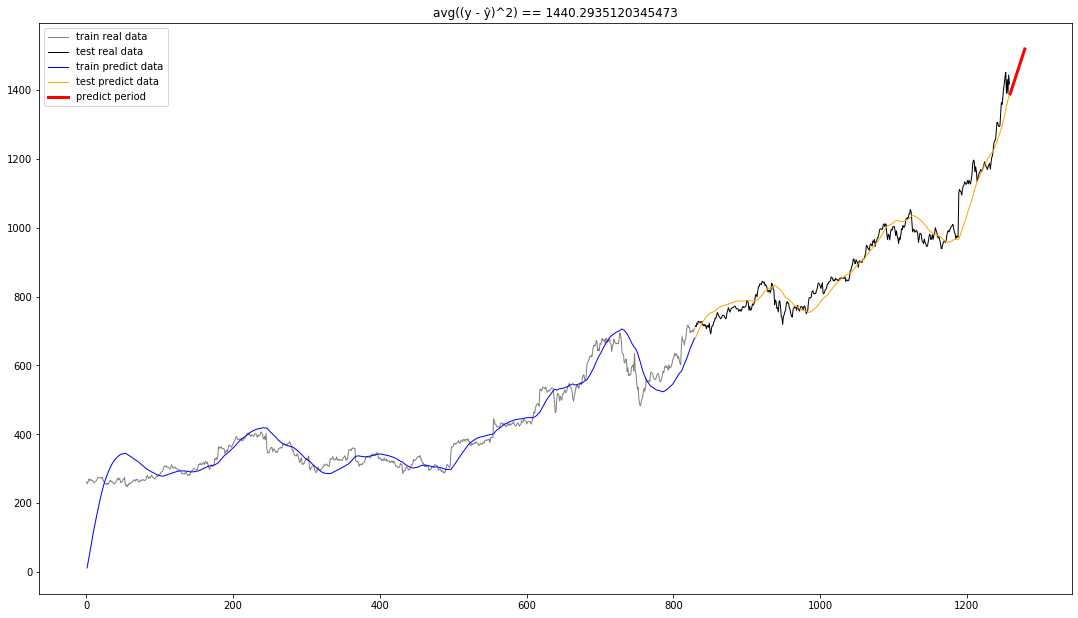

In [8]:
start_model(Holt(5, 4), *split_data(airlines), predict_period=12, is_recalculate_model=False)
start_model(Holt(5, 5), *split_data(temperature), predict_period=365, is_recalculate_model=False)
start_model(Holt(21, 21), *split_data(amazon), predict_period=21, is_recalculate_model=False)

## Модель Уинтерса

Элементы вычисляются по формуле:

$$ ŷ[t+d] = a[t] · θ[t+(d mod s)−s] $$

$$ a[t] = α1 * (y[t] / θ[t−s]) + (1 − α1 ) * a[t−1] $$
$$ θ[t] = α2 * (y[t] / a[t]) + (1 − α2 ) * θ[t−s] $$

$ θ[i] $ - сезонный профиль периода s

Данная модель не учитывает тренд, а предсказывает только сезонные колебания.

Как видно из формулы, значение $ a[t] $ характеризует среднее значение ряда, а значение θ[i] нужно для учета значений, которые были сезон назад.

In [9]:
class Winters:
    """Модель Уинтерса (только сезон)
    
    ŷ[t+d] = a[t] · θ[t+(d mod s)−s]
    
    a[t] = α1 * (y[t] / θ[t−s]) + (1 − α1 ) * a[t−1]
    θ[t] = α2 * (y[t] / a[t]) + (1 − α2 ) * θ[t−s]
    
    θ[i] - сезонный профиль периода s
    
    α[i] = 1/(p[i] + 1)

    Предсказывает только сезон, без учета тренда
    
    """

    def __init__(self, p1, p2, s):
        self.s = s
        self.o = [1] * s
        self.a = 1
        self.alpha1 = 1 / (p1 + 1)
        self.alpha2 = 1 / (p2 + 1)
        self.fit_chart = []
        self.last_prediction_y = 0

    def fit(self, y):
        for i in range(len(y)):
            if i < self.s:
                continue
            t = i - 1
            
            old_a = self.a
            self.a = self.alpha1 * (y[t] / self.o[t - self.s]) + (1 - self.alpha1) * old_a
            o = self.alpha2 * (y[t - 1] / self.a) + (1 - self.alpha2) * self.o[t - self.s]
            self.o.append(o)
            
            self.last_prediction_y = self.a * self.o[t + 1 - self.s]
            self.fit_chart.append(self.last_prediction_y)
            
        return self
    
    def predict_y(self, d=1):
        if d != 1:
            return self.a * self.o[len(self.o) + (d % self.s) - self.s]
        return self.last_prediction_y

    def append_y(self, new_y):
        last_index = len(self.o)
        
        old_a = self.a
        self.a = self.alpha1 * (new_y / self.o[last_index - self.s]) + (1 - self.alpha1) * old_a
        self.o.append(self.alpha2 * (new_y/self.a) + (1 - self.alpha2) * self.o[last_index - self.s])
        self.last_prediction_y = self.a * self.o[last_index + 1 - self.s]

Выбросы в начале связаны с 'пустыми' начальными данными.

Модель хорошо прогнозирует данные с наличием сезонности, но если в данных есть тренд, стоит воспользоваться улучшением данной модели.

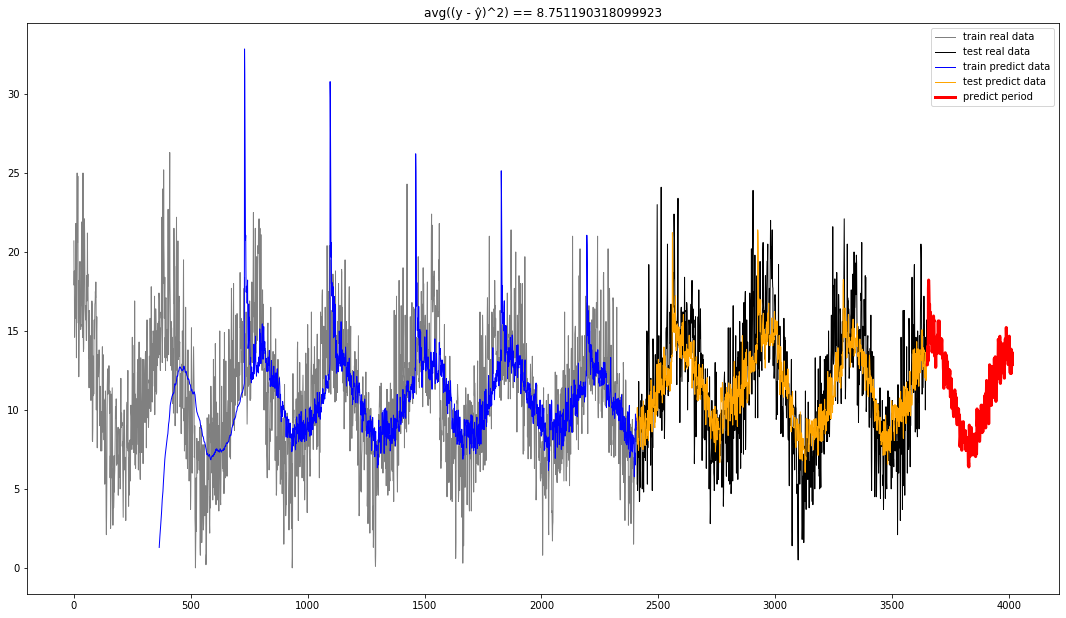

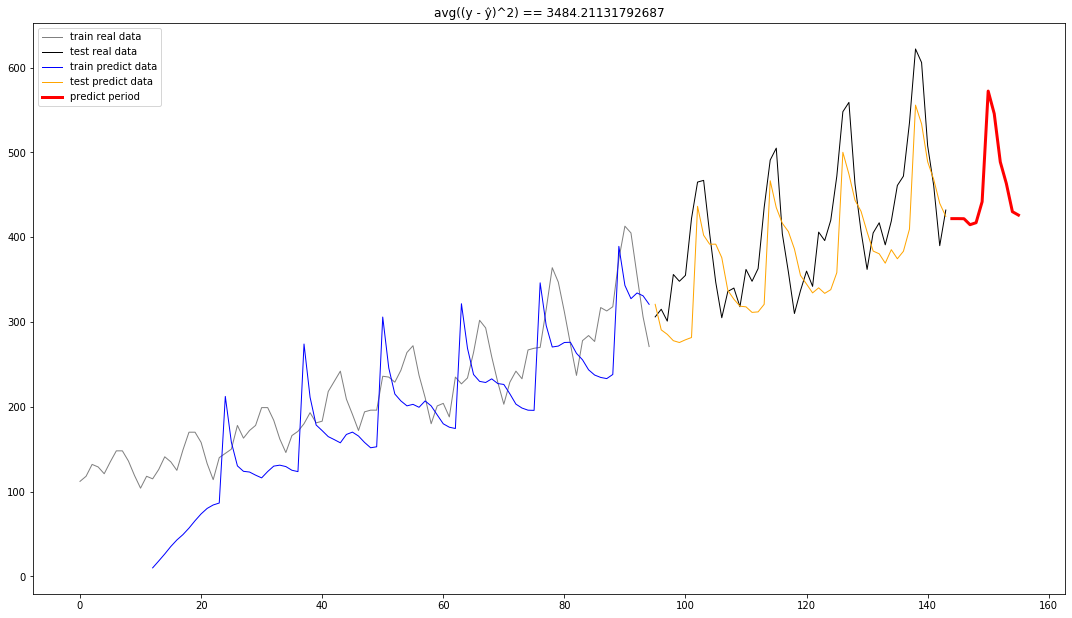

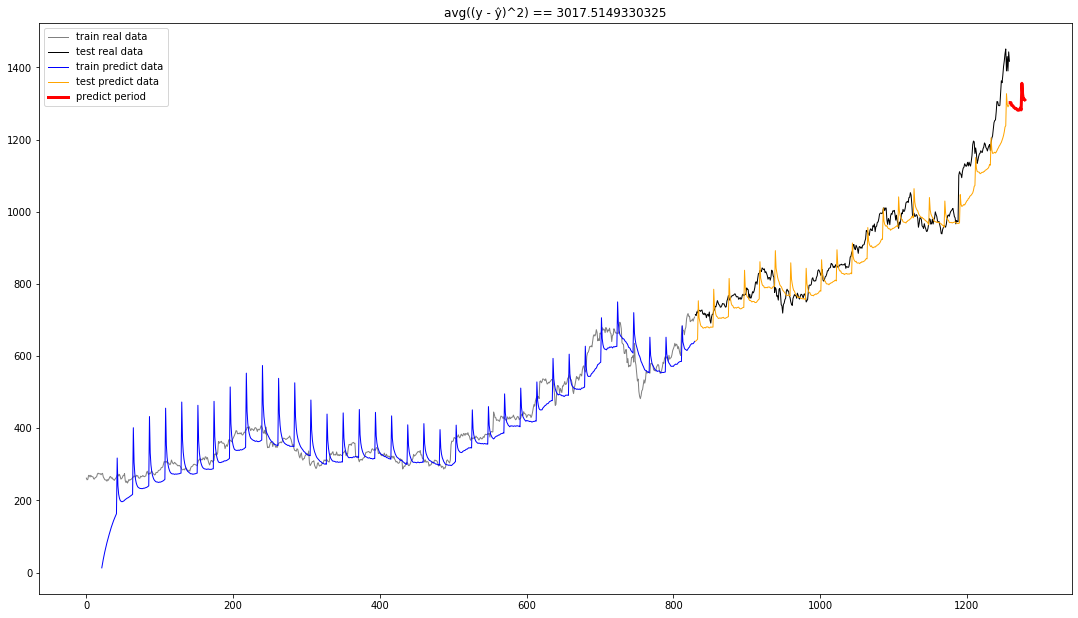

In [10]:
start_model(Winters(55, 5, 365), *split_data(temperature), predict_period=365, is_recalculate_model=False)
start_model(Winters(12, 6, 12), *split_data(airlines), predict_period=12, is_recalculate_model=False)
start_model(Winters(21, 21, 21), *split_data(amazon), predict_period=21, is_recalculate_model=False)

## Модель Уинтерса с линейным трендом

Элементы вычисляются по формуле:

$$ ŷ[t+d] = (a[t] + b[t] * d) * θ[t+(d mod s)−s] $$

$$ a[t] = α1 * (y[t] / θ[t−s]) + (1 − α1) * (a[t−1] + b[t−1]) $$
$$ b[t] = α2 * (a[t] − a[t−1]) + (1 − α2) * b[t−1] $$
$$ θ[t] = α3 * (y[t] / a[t]) + (1 − α3) * θ[t−s] $$

$ θ[i] $ - сезонный профиль периода s

Модель учитывает как тренд, так и сезонность (мультипликативную).
По формуле можно понять, что $ a[t] $ характеризует среднее значение ряда $ b[t]*d $ тенденцию к увеличению, а $ θ[t+(d mod s)−s] $ учитывает значения за прошлый сезон.

In [11]:
class WintersLineTrend:
    """Модель Уинтерса с линейным трендом
    
    ŷ[t+d] = (a[t] + b[t] * d) * θ[t+(d mod s)−s]    
    
    a[t] = α1 * (y[t] / θ[t−s]) + (1 − α1) * (a[t−1] + b[t−1])
    b[t] = α2 * (a[t] − a[t−1]) + (1 − α2) * b[t−1]
    θ[t] = α3 * (y[t] / a[t]) + (1 − α3) * θ[t−s]
    
    α[i] = 1/(p[i] + 1)
    
    Учитывает сезоны и определяет линейный тренд

    """

    def __init__(self, p1, p2, p3, s):
        self.s = s
        self.o = [1] * s
        self.a = 1
        self.b = 1
        self.alpha1 = 1 / (p1 + 1)
        self.alpha2 = 1 / (p2 + 1)
        self.alpha3 = 1 / (p3 + 1)
        self.fit_chart = []
        self.last_prediction_y = 0

    def fit(self, y):
        for i in range(len(y)):
            if i < self.s:
                continue
            t = i - 1
            i=None
            
            old_a = self.a
            old_b = self.b
            self.a = self.alpha1 * (y[t] / self.o[t - self.s]) + (1 - self.alpha1) * (old_a + old_b)
            self.b = self.alpha2 * (self.a - old_a) + (1 - self.alpha2) * old_b
            o = self.alpha3 * (y[t]/self.a) + (1 - self.alpha3) * self.o[t - self.s]
            
            self.o.append(o)
            self.last_prediction_y = (self.a + self.b) * self.o[t + 1 - self.s]
            self.fit_chart.append(self.last_prediction_y)
        return self

    def predict_y(self, d=1):
        if d != 1:
            return (self.a + self.b * d) * self.o[len(self.o) + d - self.s]
        return self.last_prediction_y

    def append_y(self, new_y):
        i = len(self.o)
        
        old_a = self.a
        old_b = self.b
        self.a = self.alpha1 * (new_y / self.o[i - self.s]) + (1 - self.alpha1) * (old_a + old_b)
        self.b = self.alpha2 * (self.a - old_a) + (1 - self.alpha2) * old_b
        o = self.alpha3 * (new_y/self.a) + (1 - self.alpha3) * self.o[i - self.s]

        self.o.append(o)
        self.last_prediction_y = (self.a + self.b) * self.o[i + 1 - self.s]

Если первая модель, фактически, продублировала предыдыдущий сезон на графике кол-ва пассажиров, то тут образовался новый пик в направлении тренда

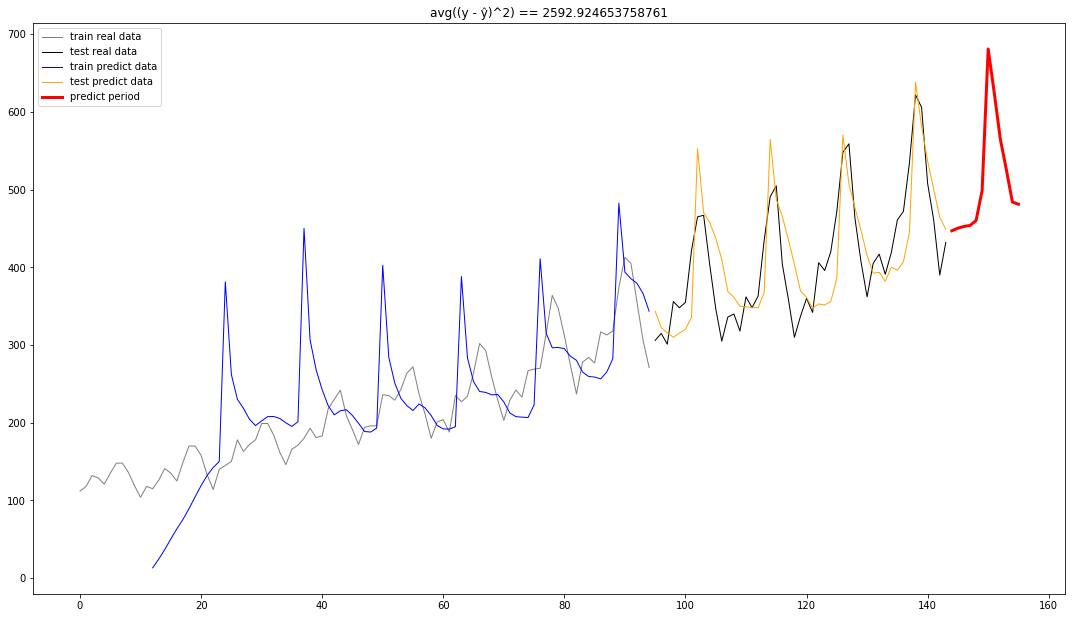

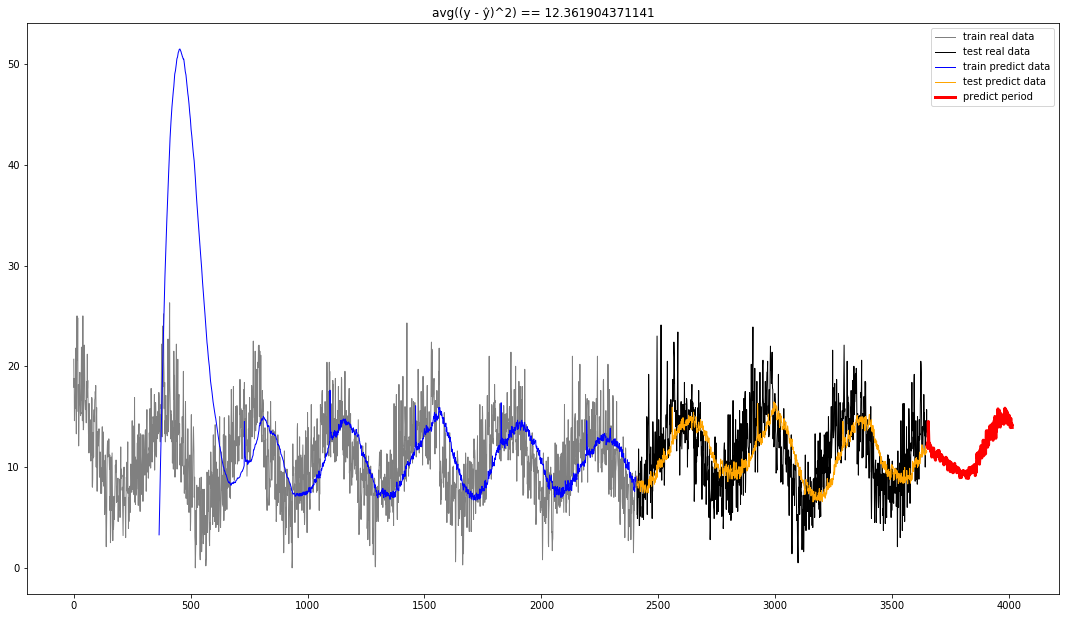

In [12]:
start_model(WintersLineTrend(12, 6, 6, 12), *split_data(airlines), is_recalculate_model=False, predict_period=12)

start_model(WintersLineTrend(55, 100, 15, 365), *split_data(temperature),
            predict_period=365, is_recalculate_model=False)

## Модель Тейла-Вейджа

Элементы вычисляются по формуле:

$$ ŷ[t+d] = (a[t] + b[t] * d) + θ[t+(d mod s)−s] $$

$$ a[t] = α1 (y[t] − θ[t−s]) + (1 − α1) * (a[t−1] + b[t−1]) $$
$$ b[t] = α2 (a[t] − a[t−1]) + (1 − α2)* b[t−1] $$
$$ θ[t] = α3 (y[t] − a[t]) + (1 − α3) * θ[t−s] $$

$ θ[i] $ - сезонный профиль периода s

Модель учитывает как тренд, так и сезонность (аддитивную).
По формуле можно понять, что $ a[t] $ характеризует среднее значение ряда $ b[t]*d $ тенденцию к увеличению, а $ θ[t+(d mod s)−s] $ учитывает значения за прошлый сезон.

От предыдущей модели модель Тейла-Вейджа отличают только знаки. Если в модели Уинтерса значения умножались на $ θ $, то тут сезонный профиль прибавляется.

Модель Тейла-Вейджа предполагает, что каждый сезон значение увеличивается не 'во сколько-то раз', а 'на сколько-то'

In [13]:
class TheilWage:
    """Модель Тейла-Вейджа
    
    ŷ[t+d] = (a[t] + b[t] * d) + θ[t+(d mod s)−s]
    
    a[t] = α1 (y[t] − θ[t−s]) + (1 − α1) * (a[t−1] + b[t−1])
    b[t] = α2 (a[t] − a[t−1]) + (1 − α2)* b[t−1]
    θ[t] = α3 (y[t] − a[t]) + (1 − α3) * θ[t−s]
    
    a, b - параметры тренда
    θ - профиль сезона
    
    """

    def __init__(self, p1, p2, p3, s):
        self.s = s
        self.o = [1] * s
        self.a = 0
        self.b = 0
        self.alpha1 = 1 / (p1 + 1)
        self.alpha2 = 1 / (p2 + 1)
        self.alpha3 = 1 / (p3 + 1)
        self.fit_chart = []
        self.last_prediction_y = 0

    def fit(self, y):
        for i in range(len(y)):
            if i < self.s:
                continue
            t = i - 1
            
            old_a = self.a
            old_b = self.b
            self.a = self.alpha1 * (y[t] - self.o[t - self.s]) + (1 - self.alpha1) * (old_a + old_b)
            self.b = self.alpha2 * (self.a - old_a) + (1 - self.alpha2) * old_b
            o = self.alpha3 * (y[t] - self.a) + (1 - self.alpha3) * self.o[t - self.s]

            self.o.append(o)
            self.last_prediction_y = (self.a + self.b) + self.o[t + 1 - self.s]
            self.fit_chart.append(self.last_prediction_y)
        return self
    
    def predict_y(self, d=1):
        if d != 1:
            return (self.a + self.b * d) + self.o[len(self.o) - 1 + d - self.s]
        return self.last_prediction_y

    def append_y(self, new_y):
        i = len(self.o)
        
        a_old = self.a
        self.a = self.alpha1 * (new_y - self.o[i - self.s]) + (1 - self.alpha1) * (self.a + self.b)
        self.b = self.alpha2 * (self.a - a_old) + (1 - self.alpha2) * self.b
        self.o.append(self.alpha3 * (new_y - self.a) + (1 - self.alpha3) * self.o[i - self.s])
        self.last_prediction_y = (self.a + self.b) + self.o[i + 1 - self.s]

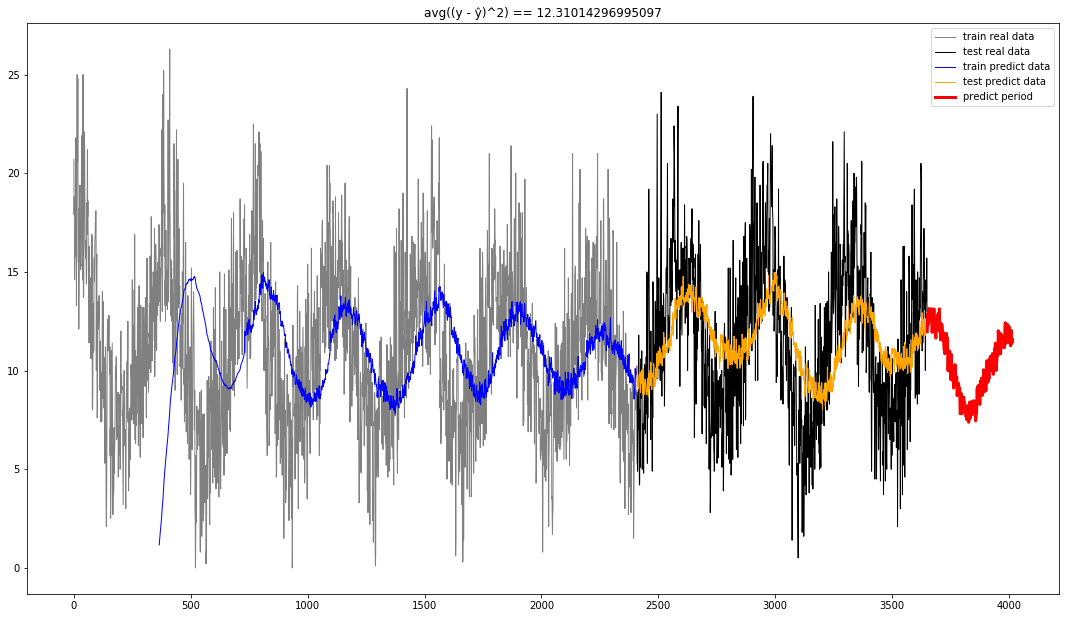

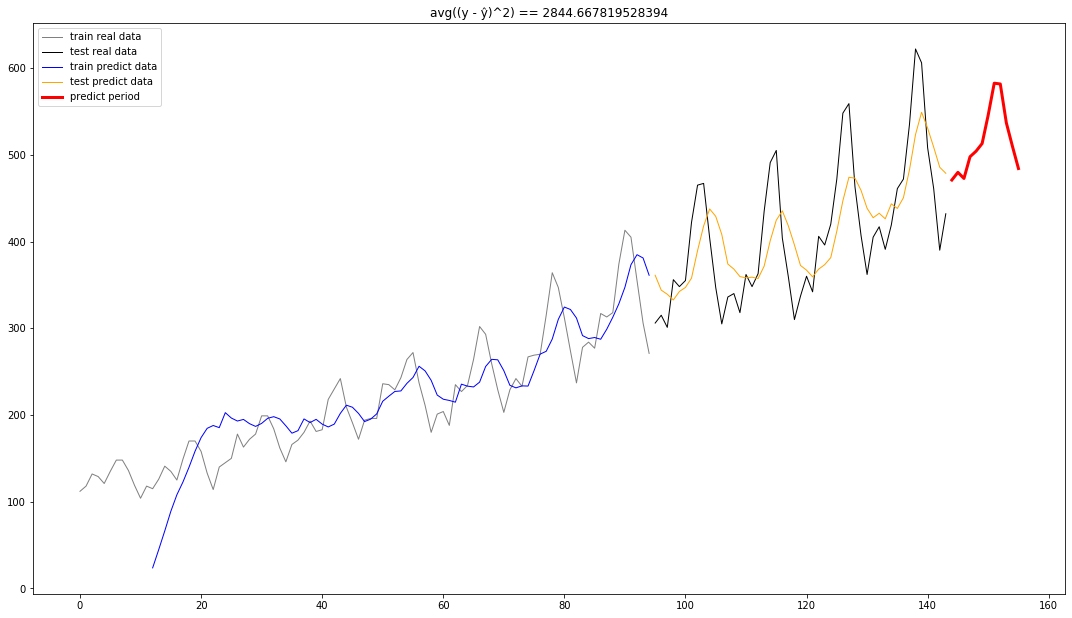

In [14]:
start_model(TheilWage(100, 100, 15, 365), *split_data(temperature), predict_period=365, is_recalculate_model=False)
start_model(TheilWage(5, 5, 5, 12), *split_data(airlines), is_recalculate_model=False, predict_period=12)

## Авторегрессионные модели и немного о моделях семейства ARMA

Данные модели способны давать достаточно точные прогнозы, но их используют только, если рядов не много, так как они долго вычисляются.

## Авторегрессия

Предполагает, что каждое значение зависит от p предыдущих.

$$ y[t]=c + ϕ1 * y[t−1] + ϕ2 * y[t−2] + ... + ϕ[p] * y[t−p] + ε[t] $$

В итоге перед нами стоит задача регрессии, которую можно решить через МНК.

In [15]:
class AR:
    """Autoregressive
    
    Модель имеет вид:
    y[t]=c + ϕ1 * y[t−1] + ϕ2 * y[t−2] + ... + ϕ[p] * y[t−p] + ε[t]
    
    Ставится задача решения регрессии ряда на p предыдущих элементов ряда
    
    """

    def __init__(self, p):
        self.p = p
        self.y = pd.DataFrame([])
        self.fit_chart = []
        self._coefficients = np.array([])
    
    def calculate_ols(self, y):
        self.y = y.copy()
        y_result = []
        F = []
        for i, y_i in enumerate(y):
            if i < self.p:
                continue
            # массив [1] нужен для вычисления константы, иначе прогноз будет смещенным
            matrix_line = [1] + [y[i - j - 1] for j in range(self.p)]
            F.insert(0, matrix_line)
            y_result.insert(0, y_i)
        y_result = np.array(np.array(y_result).reshape((-1, 1)))
        F = np.array(F, dtype='float')

        # (F.T * F)^-1 * F.T * y_result
        self._coefficients = inv(F.T.dot(F)).dot(F.T).dot(y_result)        

    def fit(self, y):
        self.calculate_ols(y)
        
        for x_i in y.index.values[self.p:]:
            y_i = self._coefficients[0, 0]
            for j in range(self.p + 1):
                if j == 0:
                    continue
                if x_i - j < 0:
                    raise IndexError
                y_i += self._coefficients[j, 0] * self.y[x_i - j]
            self.fit_chart.append(y_i)
        return self

    def predict_y(self):
        new_y = self._coefficients[0, 0]
        last_ind = self.y.last_valid_index()

        for j in range(self.p + 1):
            if j == 0:
                continue
            new_y += self._coefficients[j, 0] * self.y[last_ind - j]

        return new_y

    def append_y(self, new_y):
        self.y.loc[len(self.y)] = new_y
        self.calculate_ols(self.y)

Можно увидеть, что авторегрессия дает более сложную структуру прогноза, в сравнении с моделями на основании экспоненциальных скользящих средних

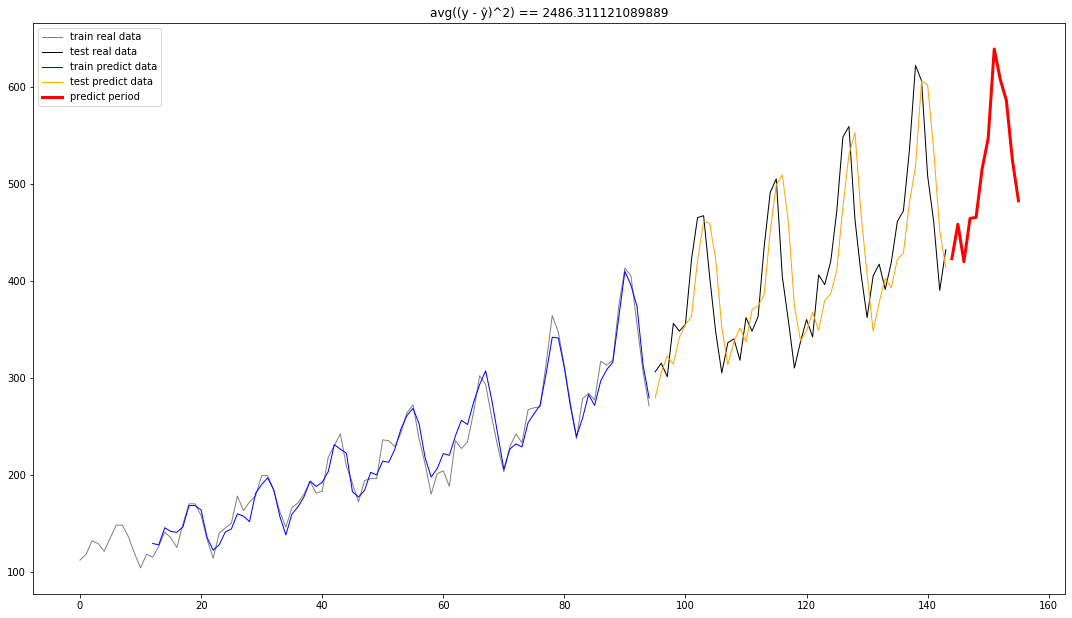

In [16]:
start_model(AR(12), *split_data(airlines), predict_period=12, is_ln=True)

## Авторегрессия

Предполагает, что каждое значение зависит от шума в предыдущие моменты времени.

$$ y[t] = c + θ[1] * ε[t-1] + θ[2] * ε[t−2] + ... + θ[q] * ε[t−q] + ε[t] $$

Шум не относится к наблюдаемым данным, поэтому за начальный набор берутся ошибки от регрессии небольшого порядка. 

In [17]:
class MA:
    """Модель moving average
    
    Модель имеет вид:
    y[t] = c + θ[1] * ε[t-1] + θ[2] * ε[t−2] + ... + θ[q] * ε[t−q] + ε[t]
    
    ε[t] - белый шум в момент t
    
    Ставится задача решения регрессии ряда на шум от вычислений
    
    """

    def __init__(self, q):
        self.q = q
        self.errors = np.array([])
        self.fit_chart = []
        self._coefficients = np.array([])
        self.y = pd.DataFrame([])
    
    def calculate_ols(self, y):
        self.y = y.copy()
        y_result = []
        F = []
        for ind, y_i in enumerate(y):
            if ind < self.q:
                continue
            matrix_line = [1] + [self.errors[ind - j - 1] for j in range(self.q)]
            F.insert(0, matrix_line)
            y_result.insert(0, y_i)
        y_result = np.array(np.array(y_result).reshape((-1, 1)))
        F = np.array(F, dtype='float')
        
        # (F.T * F)^-1 * F.T * y_result
        self._coefficients = inv(F.T.dot(F)).dot(F.T).dot(y_result)
    
    def fit(self, y):
        # Формируем начальный шум, как ошибки от простой регрессии, далее дополняем массив ошибоками от прогнозов
        
        # self.errors = np.random.standard_normal(size=len(y))
        regr_p = 1
        regr = AR(regr_p).fit(y).fit_chart
        self.errors = []
        self.errors = [y[i + regr_p] - regr[i] for i in range(len(regr))]
        self.errors = np.concatenate((np.random.standard_normal(size=regr_p), self.errors))

        self.calculate_ols(y)
        
        for x_i in y[self.q:].index.values:
            y_i = self._coefficients[0, 0]
            for j in range(self.q + 1):
                if j == 0:
                    continue
                if x_i - j < 0:
                    raise IndexError
                y_i += self._coefficients[j, 0] * self.errors[x_i - j]
            self.fit_chart.append(y_i)
        
        return self

    def predict_y(self):
        y_i = self._coefficients[0, 0]
        last_error_index = len(self.errors) - 1
        
        for j in range(self.q + 1):
            if j == 0:
                continue
            y_i += self._coefficients[j, 0] * self.errors[last_error_index - j]
        return y_i

    def append_y(self, new_y):
        self.errors = np.append(self.errors, new_y - self.predict_y())
        self.y.loc[len(self.y)] = new_y
        self.calculate_ols(self.y)

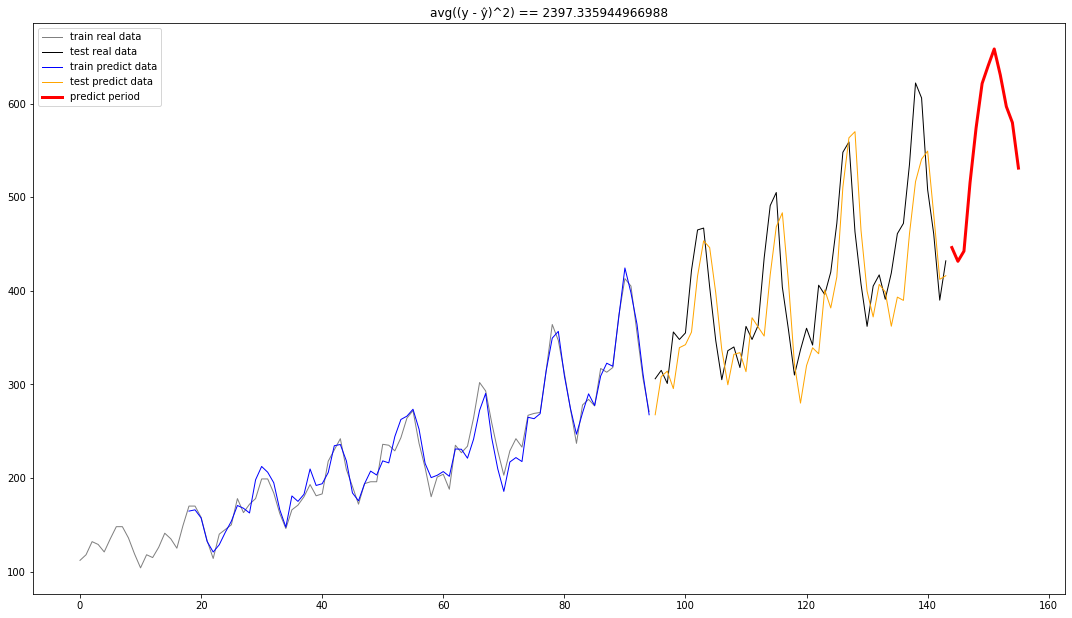

In [18]:
start_model(MA(18), *split_data(airlines), predict_period=12)

## Autoregressive-moving-average

Данная модель представляет из себя объединение моделей AR и MA

$$ y[t] = c + ϕ[1] * y[t−1] + ... + ϕ[p] * y[t−p] + θ[1] * ε[t-1] + θ[2] * ε[t−2] + ... + θ[q] * ε[t−q] + ε[t] $$


In [19]:
class ARMA:
    """Autoregressive moving average
    
    y[t] = c + 
            ϕ[1] * y[t−1] + ... + ϕ[p] * y[t−p] +
            θ[1] * ε[t-1] + θ[2] * ε[t−2] + ... + θ[q] * ε[t−q] +
            ε[t]
    
    """

    def __init__(self, p, q):
        self.p = p
        self.q = q
        self.y = pd.DataFrame([])
        self.errors = pd.array([])
        self.fit_chart = []
        self._coefficients = np.array([])
    
    def calculate_ols(self, y):
        self.y = y.copy()
        y_result = []
        F = []
        for i, y_i in enumerate(y):
            if i < self.p:
                continue
            matrix_line = [1] +\
                          [y[i - j - 1] for j in range(self.p)] +\
                          [self.errors[i - j - 1] for j in range(self.q)]
            F.insert(0, matrix_line)
            y_result.insert(0, y_i)
        y_result = np.array(np.array(y_result).reshape((-1, 1)))
        F = np.array(F, dtype='float')

        # (F.T * F)^-1 * F.T * y_result
        self._coefficients = inv(F.T.dot(F)).dot(F.T).dot(y_result)
    
    def fit(self, y):
        # Формируем начальный шум, как ошибки от простой регрессии, далее дополняем массив ошибоками от прогнозов
        
        # self.errors = np.random.standard_normal(size=len(y))
        regr = AR(self.p).fit(y).fit_chart
        self.errors = []
        for i in range(len(regr)):
            self.errors.append(y[i + self.p] - regr[i])
        self.errors = np.concatenate((np.random.standard_normal(size=self.p), self.errors))

        self.calculate_ols(y)
        
        for x_i in y[max(self.p, self.q):].index.values:
            y_i = self._coefficients[0, 0]

            regr_coefficients = self._coefficients[1:self.p + 1]
            for j, coeff in enumerate(regr_coefficients):
                y_i += coeff[0] * self.y[x_i - j - 1]

            moving_coefficients = self._coefficients[self.p + 1:]
            for j, coeff in enumerate(moving_coefficients):
                y_i += coeff[0] * self.errors[x_i - j - 1]
            self.fit_chart.append(y_i)
        
        return self

    def predict_y(self):
        new_y = self._coefficients[0, 0]
        last_ind = self.y.last_valid_index()

        regr_coeff = self._coefficients[1:self.p + 1]
        for j, coeff in enumerate(regr_coeff):
            new_y += coeff[0] * self.y[last_ind - j - 1]

        moving_coeff = self._coefficients[self.p + 1:]
        for j, coeff in enumerate(moving_coeff):
            new_y += coeff[0] * self.errors[last_ind - j - 1]

        return new_y

    def append_y(self, new_y):
        self.errors = np.append(self.errors, new_y - self.predict_y())
        self.y.loc[len(self.y)] = new_y
        self.calculate_ols(self.y)

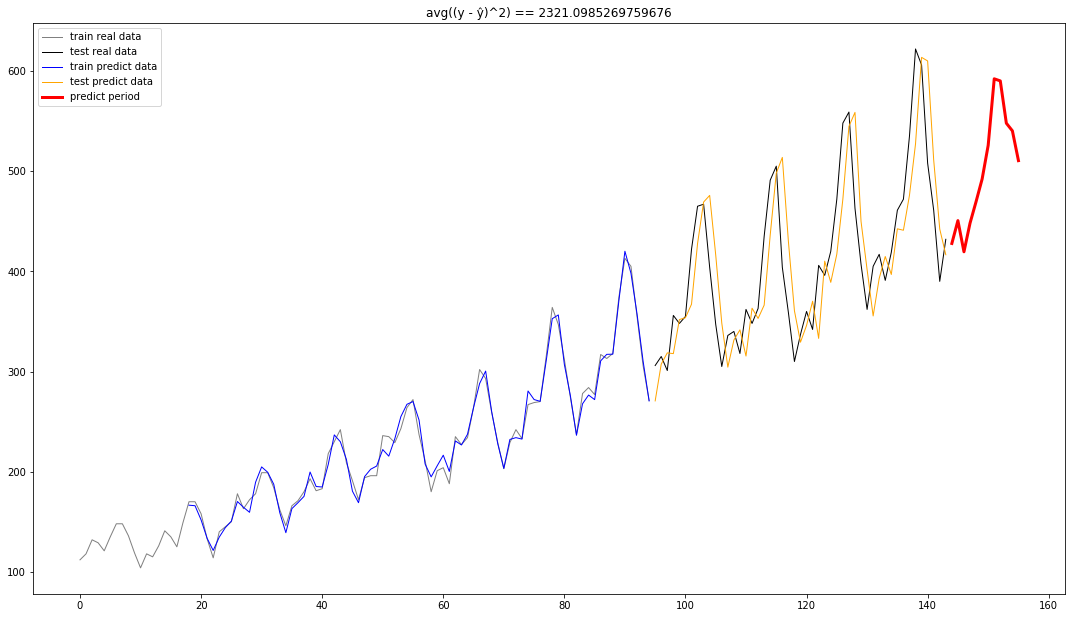

In [20]:
start_model(ARMA(12, 18), *split_data(airlines), predict_period=12)

Есть и другие модели семейства ARMA, например ARIMA добавляется дифференцирование для получения стационарного ряда.

## Выводы

Были рассмотрены различные модели, учитывающие разные явления временных рядов.

- Некоторые преобразования ряда до прогнозирования могут улучшить прогноз.
- Модели на основании экспоненциальных средних могут прогнозировать процессы временных рядов.
- Для вычисления большого числа рядов имеет смысл пользоваться моделями на основании экспоненциальных средних, так как все вычисления упираются в несколько формул.
- Если требуется получить прогноз с сложной структурой и есть время на рассчеты, то можно воспользоваться одной из авторегрессионных моделей.
- Сильное влияние оказывают параметры моделей. В случае с моделями основанными на скользящих средних, чем больший период усреднения, тем менее чувствительной становится модель. Она становится меньше реагирует на выбросы, но может сильно запаздывать от реальных данных.
- В случае, если рядов очень много, можно построить систему, которая паралельно высчитыват ошибки разных моделей и выбирает лучшую для конкретного ряда в данный момент времени.